# Обучение модели TF-IDF + CatBoostClassifier

## Подготовка среды и агрузка данных

In [1]:
!pip install pymystem3 python-rake wordcloud gensim pyLDAvis

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from yellowbrick.classifier import ClassificationReport
import pandas_profiling

import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score,precision_score,recall_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import optuna

import warnings

warnings.filterwarnings('ignore')


/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/visions/backends/shared/nan_handling.py:

In [3]:
RANDOM_STATE = 12345
targets = 'Категория'

In [4]:
df = pd.read_csv('table_for_category_classification.csv', sep=',', on_bad_lines='skip')

In [5]:
df

,Название,Категория
0,"Стоимость организации услуг, в т.ч. НДС",Прочее
1,Тональная аудиометрия с тестом Вебера,Инструментальная диагностика
2,Тимпанометрия,Инструментальная диагностика
3,Офтальмотонометрия,Инструментальная диагностика
4,Офтальмохромоскопия,Инструментальная диагностика
...,...,...
8447,Осмотр (консультация) врача-физиотерапевта пер...,Консультация специалиста
8448,Консультация врача-гематолога повторная,Консультация специалиста
8449,Консультация врача - уролога (на дому /в офисе),Консультация специалиста
8450,Консультация врача лечебной физкультуры повтор...,Консультация специалиста


## Предобработка данных

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8452 entries, 0 to 8451
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Название   8452 non-null   object
 1   Категория  8452 non-null   object
dtypes: object(2)
memory usage: 132.2+ KB


In [8]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4313 entries, 0 to 7951
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Название   4313 non-null   object
 1   Категория  4313 non-null   object
dtypes: object(2)
memory usage: 101.1+ KB


In [9]:

def clean_text(text):
    '''
    Подготовка текстовых данных:
    - применение к нижнему регистру
    - регулярное выражение для удаления лишних символов
    - замена числа и цифры на ' num '
    - удаление лишних пробелов
    
    входные данные - текстовые
    возвращает подготовленные данные данные
    '''
    text = text.lower()
    regular = r'[\*+\#+\№\"\-+\+\=+\?+\&\^\.+\;\,+\>+\(\)\/+\:\\+]'
    text = re.sub(regular, '', text)
    text = re.sub(r'(\d+\s\d+)|(\d+)',' num ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

# создаем список для хранения преобразованных данных 
processed_text = []
stop_words = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д', '-', '-',
                                           'который','прошлый','сей', 'свой', 'наш', 'мочь', 'ик', 'акг', 'экг', 
                                            'мм', 'фк', 'ч' ]
# инициализируем лемматайзер 
lemmatizer = WordNetLemmatizer()
 

for text in df['Название']:
    text = clean_text(text)   
    text = word_tokenize(text)       
    text = [word for word in text if word not in stop_words]     
    text = [lemmatizer.lemmatize(w) for w in text]
    processed_text.append(text)

In [10]:
df['Processed_msg'] = processed_text
df['Processed_msg'] = df['Processed_msg'].astype(str)
#удаление лишних столбцов
df.drop(['Название'],
        axis= 1 , inplace= True )

In [11]:
#переименование категорий
level_map = {'Прочее':0, 'Инструментальная диагностика':1, 'Манипуляция':2,
       'Консультация специалиста':3, 'Лабораторная диагностика':4}
df['Категория'] = df['Категория'].map(level_map)
df['Категория'] = df['Категория'].astype('int64')

In [12]:
y = df['Категория']
X = df.drop(['Категория'], axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.4,random_state=1234, stratify=y)
    
X_valid, X_test, y_valid, y_test = train_test_split(X_valid,y_valid,test_size=0.5,random_state=1234)
#Преобразование набора необработанных документов в матрицу функций TF-IDF.
count_tf = TfidfVectorizer(ngram_range=(1, 2))

X_train = count_tf.fit_transform(X_train['Processed_msg'])
X_valid = count_tf.transform(X_valid['Processed_msg'])
X_test = count_tf.transform(X_test['Processed_msg'])

print(X_train.shape, X_valid.shape, X_test.shape)

(2587, 8326) (863, 8326) (863, 8326)


## Обучение моделей
### CatBoostClassifier базовый

In [13]:
model_bas_cb = CatBoostClassifier(random_state=RANDOM_STATE)
model_bas_cb.fit(X_train, y_train)

Learning rate set to 0.083057
0:	learn: 1.4164995	total: 97ms	remaining: 1m 36s
1:	learn: 1.2926726	total: 138ms	remaining: 1m 8s
2:	learn: 1.1894208	total: 182ms	remaining: 1m
3:	learn: 1.1079288	total: 223ms	remaining: 55.5s
4:	learn: 1.0360791	total: 265ms	remaining: 52.6s
5:	learn: 0.9833052	total: 302ms	remaining: 50s
6:	learn: 0.9286229	total: 340ms	remaining: 48.3s
7:	learn: 0.8789639	total: 379ms	remaining: 47s
8:	learn: 0.8412367	total: 417ms	remaining: 45.9s
9:	learn: 0.8027643	total: 454ms	remaining: 45s
10:	learn: 0.7695760	total: 493ms	remaining: 44.3s
11:	learn: 0.7420468	total: 532ms	remaining: 43.8s
12:	learn: 0.7171586	total: 571ms	remaining: 43.3s
13:	learn: 0.6946431	total: 609ms	remaining: 42.9s
14:	learn: 0.6745175	total: 646ms	remaining: 42.4s
15:	learn: 0.6579778	total: 684ms	remaining: 42.1s
16:	learn: 0.6381287	total: 722ms	remaining: 41.8s
17:	learn: 0.6230397	total: 757ms	remaining: 41.3s
18:	learn: 0.6090187	total: 793ms	remaining: 41s
19:	learn: 0.5952346	t

161:	learn: 0.3334905	total: 6.27s	remaining: 32.4s
162:	learn: 0.3329195	total: 6.3s	remaining: 32.4s
163:	learn: 0.3324740	total: 6.34s	remaining: 32.3s
164:	learn: 0.3319317	total: 6.38s	remaining: 32.3s
165:	learn: 0.3310020	total: 6.42s	remaining: 32.3s
166:	learn: 0.3307016	total: 6.46s	remaining: 32.2s
167:	learn: 0.3300290	total: 6.5s	remaining: 32.2s
168:	learn: 0.3297284	total: 6.54s	remaining: 32.1s
169:	learn: 0.3294037	total: 6.58s	remaining: 32.1s
170:	learn: 0.3287972	total: 6.62s	remaining: 32.1s
171:	learn: 0.3283536	total: 6.66s	remaining: 32s
172:	learn: 0.3282259	total: 6.7s	remaining: 32s
173:	learn: 0.3279092	total: 6.74s	remaining: 32s
174:	learn: 0.3276243	total: 6.77s	remaining: 31.9s
175:	learn: 0.3271323	total: 6.81s	remaining: 31.9s
176:	learn: 0.3267636	total: 6.85s	remaining: 31.9s
177:	learn: 0.3263996	total: 6.89s	remaining: 31.8s
178:	learn: 0.3259485	total: 6.93s	remaining: 31.8s
179:	learn: 0.3256903	total: 6.96s	remaining: 31.7s
180:	learn: 0.3251499

320:	learn: 0.2780751	total: 12.3s	remaining: 26.1s
321:	learn: 0.2779708	total: 12.4s	remaining: 26.1s
322:	learn: 0.2777688	total: 12.4s	remaining: 26s
323:	learn: 0.2775728	total: 12.4s	remaining: 26s
324:	learn: 0.2773989	total: 12.5s	remaining: 25.9s
325:	learn: 0.2772720	total: 12.5s	remaining: 25.9s
326:	learn: 0.2770984	total: 12.6s	remaining: 25.9s
327:	learn: 0.2769707	total: 12.6s	remaining: 25.8s
328:	learn: 0.2768314	total: 12.6s	remaining: 25.8s
329:	learn: 0.2766681	total: 12.7s	remaining: 25.7s
330:	learn: 0.2764442	total: 12.7s	remaining: 25.7s
331:	learn: 0.2761622	total: 12.8s	remaining: 25.7s
332:	learn: 0.2759257	total: 12.8s	remaining: 25.6s
333:	learn: 0.2756817	total: 12.8s	remaining: 25.6s
334:	learn: 0.2754739	total: 12.9s	remaining: 25.5s
335:	learn: 0.2752867	total: 12.9s	remaining: 25.5s
336:	learn: 0.2746619	total: 12.9s	remaining: 25.5s
337:	learn: 0.2745021	total: 13s	remaining: 25.4s
338:	learn: 0.2742800	total: 13s	remaining: 25.4s
339:	learn: 0.274162

481:	learn: 0.2461211	total: 18.5s	remaining: 19.9s
482:	learn: 0.2460001	total: 18.6s	remaining: 19.9s
483:	learn: 0.2459038	total: 18.6s	remaining: 19.9s
484:	learn: 0.2458102	total: 18.7s	remaining: 19.8s
485:	learn: 0.2456916	total: 18.7s	remaining: 19.8s
486:	learn: 0.2455931	total: 18.7s	remaining: 19.7s
487:	learn: 0.2452685	total: 18.8s	remaining: 19.7s
488:	learn: 0.2451420	total: 18.8s	remaining: 19.7s
489:	learn: 0.2449896	total: 18.9s	remaining: 19.6s
490:	learn: 0.2448675	total: 18.9s	remaining: 19.6s
491:	learn: 0.2447869	total: 18.9s	remaining: 19.6s
492:	learn: 0.2447086	total: 19s	remaining: 19.5s
493:	learn: 0.2445919	total: 19s	remaining: 19.5s
494:	learn: 0.2445187	total: 19.1s	remaining: 19.4s
495:	learn: 0.2443598	total: 19.1s	remaining: 19.4s
496:	learn: 0.2442712	total: 19.1s	remaining: 19.4s
497:	learn: 0.2441060	total: 19.2s	remaining: 19.3s
498:	learn: 0.2440280	total: 19.2s	remaining: 19.3s
499:	learn: 0.2439567	total: 19.2s	remaining: 19.2s
500:	learn: 0.24

641:	learn: 0.2280403	total: 24.7s	remaining: 13.8s
642:	learn: 0.2279867	total: 24.8s	remaining: 13.8s
643:	learn: 0.2279001	total: 24.8s	remaining: 13.7s
644:	learn: 0.2278134	total: 24.9s	remaining: 13.7s
645:	learn: 0.2275285	total: 24.9s	remaining: 13.6s
646:	learn: 0.2274448	total: 24.9s	remaining: 13.6s
647:	learn: 0.2273330	total: 25s	remaining: 13.6s
648:	learn: 0.2272637	total: 25s	remaining: 13.5s
649:	learn: 0.2272042	total: 25.1s	remaining: 13.5s
650:	learn: 0.2271242	total: 25.1s	remaining: 13.5s
651:	learn: 0.2270567	total: 25.2s	remaining: 13.4s
652:	learn: 0.2269794	total: 25.2s	remaining: 13.4s
653:	learn: 0.2269246	total: 25.2s	remaining: 13.4s
654:	learn: 0.2268431	total: 25.3s	remaining: 13.3s
655:	learn: 0.2262663	total: 25.3s	remaining: 13.3s
656:	learn: 0.2261915	total: 25.4s	remaining: 13.2s
657:	learn: 0.2260657	total: 25.4s	remaining: 13.2s
658:	learn: 0.2259786	total: 25.4s	remaining: 13.2s
659:	learn: 0.2258982	total: 25.5s	remaining: 13.1s
660:	learn: 0.22

802:	learn: 0.2104968	total: 31s	remaining: 7.6s
803:	learn: 0.2103656	total: 31s	remaining: 7.56s
804:	learn: 0.2102854	total: 31.1s	remaining: 7.52s
805:	learn: 0.2102247	total: 31.1s	remaining: 7.48s
806:	learn: 0.2101727	total: 31.1s	remaining: 7.45s
807:	learn: 0.2100622	total: 31.2s	remaining: 7.41s
808:	learn: 0.2099912	total: 31.2s	remaining: 7.37s
809:	learn: 0.2099281	total: 31.2s	remaining: 7.33s
810:	learn: 0.2098605	total: 31.3s	remaining: 7.29s
811:	learn: 0.2097948	total: 31.3s	remaining: 7.25s
812:	learn: 0.2097336	total: 31.4s	remaining: 7.21s
813:	learn: 0.2095204	total: 31.4s	remaining: 7.17s
814:	learn: 0.2094563	total: 31.4s	remaining: 7.14s
815:	learn: 0.2089473	total: 31.5s	remaining: 7.1s
816:	learn: 0.2083172	total: 31.5s	remaining: 7.06s
817:	learn: 0.2075996	total: 31.6s	remaining: 7.02s
818:	learn: 0.2075232	total: 31.6s	remaining: 6.98s
819:	learn: 0.2074464	total: 31.6s	remaining: 6.94s
820:	learn: 0.2073999	total: 31.7s	remaining: 6.91s
821:	learn: 0.2072

964:	learn: 0.1945077	total: 37.2s	remaining: 1.35s
965:	learn: 0.1944592	total: 37.2s	remaining: 1.31s
966:	learn: 0.1943491	total: 37.3s	remaining: 1.27s
967:	learn: 0.1942805	total: 37.3s	remaining: 1.23s
968:	learn: 0.1941746	total: 37.3s	remaining: 1.19s
969:	learn: 0.1941315	total: 37.4s	remaining: 1.16s
970:	learn: 0.1939892	total: 37.4s	remaining: 1.12s
971:	learn: 0.1939012	total: 37.4s	remaining: 1.08s
972:	learn: 0.1938186	total: 37.5s	remaining: 1.04s
973:	learn: 0.1937669	total: 37.5s	remaining: 1s
974:	learn: 0.1936564	total: 37.6s	remaining: 963ms
975:	learn: 0.1935519	total: 37.6s	remaining: 924ms
976:	learn: 0.1934772	total: 37.6s	remaining: 886ms
977:	learn: 0.1933994	total: 37.7s	remaining: 847ms
978:	learn: 0.1933367	total: 37.7s	remaining: 809ms
979:	learn: 0.1932706	total: 37.7s	remaining: 770ms
980:	learn: 0.1932046	total: 37.8s	remaining: 732ms
981:	learn: 0.1931561	total: 37.8s	remaining: 693ms
982:	learn: 0.1931054	total: 37.8s	remaining: 655ms
983:	learn: 0.1

0.9130938586326767
              precision    recall  f1-score   support

           0       1.00      0.76      0.86        29
           1       0.98      0.71      0.82       137
           2       0.88      0.29      0.44        24
           3       1.00      0.98      0.99       440
           4       0.77      1.00      0.87       233

    accuracy                           0.91       863
   macro avg       0.92      0.75      0.80       863
weighted avg       0.93      0.91      0.91       863



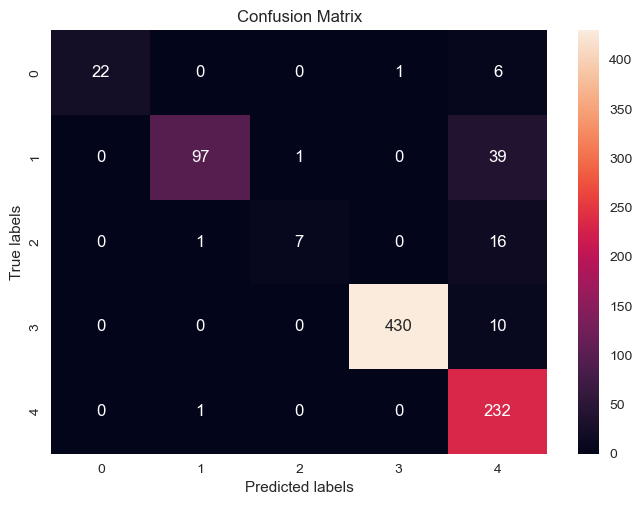

In [14]:
y_pred = model_bas_cb.predict(X_valid)

# Вывод результатов
print(accuracy_score(y_valid, y_pred))
print(classification_report(y_valid,y_pred))

T5_lables = ['0', '1', '2','3', '4']    

ax= plt.subplot()

cmm = confusion_matrix(y_valid,y_pred)
sns.heatmap(cmm, annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

На валлидационной выборке точность 0.913, хуже всего модель определяет 2 класс - Манипуляция. Попробуем улучшить метрику путем подбора гиперпараметров.

### CatBoostClassifier с подбором гиперпараметров

In [18]:
def objective(trial):
    param = {
        "random_state": RANDOM_STATE,
        #"learnng_rate": trial.suggest_float("learning_rate", 0.05, 0.7),
        "depth": trial.suggest_int("depth", 1, 12),
        'iterations'    : trial.suggest_int("iterations", 100, 600)
    }

    gbm = CatBoostClassifier(**param)

    gbm.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],early_stopping_rounds=100,
            verbose=1000)

    preds = gbm.predict(X_valid)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(y_valid, pred_labels)
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)


In [21]:
study.best_value

0.9188876013904983

In [27]:
study.best_params

{'depth': 10, 'iterations': 583}

In [23]:
tuned_params=study.best_params
tuned_params['random_state'] = RANDOM_STATE

Подбор гиперпараметров позволил улучшить качество модели: на валлидационной выборке точность 0.919.

### Проверка финальной модели на тестовых данных

In [24]:
model_cb_tuned = CatBoostClassifier(**tuned_params)
model_cb_tuned.fit(X_train, y_train)

Learning rate set to 0.131035
0:	learn: 1.3178817	total: 415ms	remaining: 4m 1s
1:	learn: 1.1528294	total: 754ms	remaining: 3m 38s
2:	learn: 1.0206081	total: 1.12s	remaining: 3m 36s
3:	learn: 0.9247342	total: 1.48s	remaining: 3m 33s
4:	learn: 0.8484655	total: 1.83s	remaining: 3m 31s
5:	learn: 0.7891027	total: 2.16s	remaining: 3m 27s
6:	learn: 0.7380048	total: 2.49s	remaining: 3m 25s
7:	learn: 0.6940922	total: 2.83s	remaining: 3m 23s
8:	learn: 0.6558897	total: 3.18s	remaining: 3m 22s
9:	learn: 0.6208375	total: 3.54s	remaining: 3m 22s
10:	learn: 0.5949843	total: 3.89s	remaining: 3m 22s
11:	learn: 0.5734368	total: 4.23s	remaining: 3m 21s
12:	learn: 0.5527351	total: 4.59s	remaining: 3m 21s
13:	learn: 0.5365254	total: 4.93s	remaining: 3m 20s
14:	learn: 0.5218918	total: 5.27s	remaining: 3m 19s
15:	learn: 0.5064146	total: 5.67s	remaining: 3m 20s
16:	learn: 0.4944306	total: 6.01s	remaining: 3m 20s
17:	learn: 0.4835190	total: 6.39s	remaining: 3m 20s
18:	learn: 0.4770497	total: 6.81s	remaining: 

157:	learn: 0.2596395	total: 55.1s	remaining: 2m 28s
158:	learn: 0.2594153	total: 55.4s	remaining: 2m 27s
159:	learn: 0.2588550	total: 55.8s	remaining: 2m 27s
160:	learn: 0.2583413	total: 56.1s	remaining: 2m 27s
161:	learn: 0.2578409	total: 56.4s	remaining: 2m 26s
162:	learn: 0.2575421	total: 56.8s	remaining: 2m 26s
163:	learn: 0.2568008	total: 57.1s	remaining: 2m 25s
164:	learn: 0.2564650	total: 57.5s	remaining: 2m 25s
165:	learn: 0.2559932	total: 57.8s	remaining: 2m 25s
166:	learn: 0.2556333	total: 58.2s	remaining: 2m 24s
167:	learn: 0.2551893	total: 58.5s	remaining: 2m 24s
168:	learn: 0.2548881	total: 58.9s	remaining: 2m 24s
169:	learn: 0.2527119	total: 59.2s	remaining: 2m 23s
170:	learn: 0.2522223	total: 59.5s	remaining: 2m 23s
171:	learn: 0.2518690	total: 59.9s	remaining: 2m 23s
172:	learn: 0.2513155	total: 1m	remaining: 2m 22s
173:	learn: 0.2510274	total: 1m	remaining: 2m 22s
174:	learn: 0.2506065	total: 1m	remaining: 2m 21s
175:	learn: 0.2503507	total: 1m 1s	remaining: 2m 21s
17

311:	learn: 0.2028485	total: 1m 47s	remaining: 1m 33s
312:	learn: 0.2027150	total: 1m 47s	remaining: 1m 32s
313:	learn: 0.2025149	total: 1m 48s	remaining: 1m 32s
314:	learn: 0.2022977	total: 1m 48s	remaining: 1m 32s
315:	learn: 0.2020535	total: 1m 48s	remaining: 1m 31s
316:	learn: 0.2018786	total: 1m 49s	remaining: 1m 31s
317:	learn: 0.2016831	total: 1m 49s	remaining: 1m 31s
318:	learn: 0.2014898	total: 1m 49s	remaining: 1m 30s
319:	learn: 0.2013349	total: 1m 50s	remaining: 1m 30s
320:	learn: 0.2011862	total: 1m 50s	remaining: 1m 30s
321:	learn: 0.2008921	total: 1m 50s	remaining: 1m 29s
322:	learn: 0.2004685	total: 1m 51s	remaining: 1m 29s
323:	learn: 0.2001995	total: 1m 51s	remaining: 1m 29s
324:	learn: 0.2000624	total: 1m 51s	remaining: 1m 28s
325:	learn: 0.1999182	total: 1m 52s	remaining: 1m 28s
326:	learn: 0.1996845	total: 1m 52s	remaining: 1m 28s
327:	learn: 0.1994792	total: 1m 52s	remaining: 1m 27s
328:	learn: 0.1993400	total: 1m 53s	remaining: 1m 27s
329:	learn: 0.1991786	total:

466:	learn: 0.1741766	total: 2m 39s	remaining: 39.7s
467:	learn: 0.1740635	total: 2m 39s	remaining: 39.3s
468:	learn: 0.1739157	total: 2m 40s	remaining: 39s
469:	learn: 0.1736071	total: 2m 40s	remaining: 38.6s
470:	learn: 0.1734906	total: 2m 40s	remaining: 38.3s
471:	learn: 0.1732883	total: 2m 41s	remaining: 37.9s
472:	learn: 0.1731862	total: 2m 41s	remaining: 37.6s
473:	learn: 0.1730866	total: 2m 41s	remaining: 37.2s
474:	learn: 0.1729695	total: 2m 42s	remaining: 36.9s
475:	learn: 0.1728369	total: 2m 42s	remaining: 36.5s
476:	learn: 0.1726711	total: 2m 42s	remaining: 36.2s
477:	learn: 0.1725482	total: 2m 43s	remaining: 35.9s
478:	learn: 0.1724534	total: 2m 43s	remaining: 35.5s
479:	learn: 0.1723090	total: 2m 43s	remaining: 35.2s
480:	learn: 0.1722056	total: 2m 44s	remaining: 34.8s
481:	learn: 0.1718471	total: 2m 44s	remaining: 34.5s
482:	learn: 0.1717385	total: 2m 44s	remaining: 34.1s
483:	learn: 0.1716309	total: 2m 45s	remaining: 33.8s
484:	learn: 0.1710248	total: 2m 45s	remaining: 3

0.9304750869061413
              precision    recall  f1-score   support

           0       0.79      0.76      0.77        29
           1       0.97      0.82      0.89       134
           2       1.00      0.38      0.55        29
           3       1.00      0.99      0.99       464
           4       0.80      0.98      0.88       207

    accuracy                           0.93       863
   macro avg       0.91      0.78      0.82       863
weighted avg       0.94      0.93      0.93       863



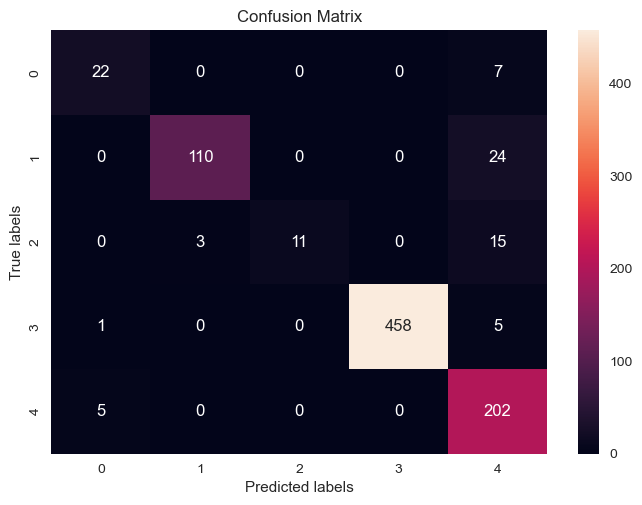

In [26]:
y_pred = model_cb_tuned.predict(X_test)

# Вывод результатов
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test,y_pred))

T5_lables = ['0', '1', '2','3', '4']    

ax= plt.subplot()

cmm = confusion_matrix(y_test,y_pred)
sns.heatmap(cmm, annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

In [29]:
print(model_cb_tuned.get_all_params())

{'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 583, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [0, 1, 2, 3, 4], 'random_seed': 12345, 'depth': 10, 'posterior_sampling': False, 'border_count': 254, 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'MultiClass', 'learning_rate': 0.1310350000858307, 'score_func

## Вывод


Модель TF-IDF + CatBoostClassifier с подобранными гиперпараметрами позволила достигнуть результата accuracy = 0.93. 


В данном направлении можно пробовать подбор большего количества гиперпараметров c целью улучшения метрики. 